# Get the names and indexes of the response genes.

In [2]:
import numpy as np
import pandas as pd
import os

import os
import torch

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.models.monet_ae import MonetDense
from spatial.predict import test

import hydra
from hydra.experimental import compose, initialize

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["OMP_NUM_THREADS"]="1"
os.environ["CUDA_VISIBLE_DEVICES"] = "5,6,7"

In [29]:
response_genes=np.array(['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36',
       'Baiap2', 'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch',
       'Col25a1', 'Cplx3', 'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1',
       'Cyp26a1', 'Dgkk', 'Ebf3', 'Egr2', 'Ermn', 'Esr1', 'Etv1',
       'Fbxw13', 'Fezf1', 'Gbx2', 'Gda', 'Gem', 'Gjc3', 'Greb1',
       'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a', 'Mbp', 'Mki67',
       'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nnat', 'Nos1',
       'Npas1', 'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x',
       'Pgr', 'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn',
       'Serpinb1b', 'Sgk1', 'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4',
       'Sln', 'Sox4', 'Sox6', 'Sox8', 'Sp9', 'Synpr', 'Syt2', 'Syt4',
       'Sytl4', 'Th', 'Tiparp', 'Tmem108', 'Traf4', 'Ttn', 'Ttyh2'])

In [30]:
data = pd.read_csv("../data/raw/merfish.csv")

In [32]:
data = data.drop(["Fos", "Blank_1", "Blank_2", "Blank_3", "Blank_4", "Blank_5"], axis=1)

In [34]:
data = data.iloc[:, 9:]

In [36]:
data.shape, data.columns # should start with "Ace2"

((1027848, 155),
 Index(['Ace2', 'Adora2a', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar',
        'Arhgap36', 'Avpr1a', 'Avpr2',
        ...
        'Penk', 'Scg2', 'Sln', 'Sst', 'Tac1', 'Tac2', 'Th', 'Trh', 'Ucn3',
        'Vgf'],
       dtype='object', length=155))

In [13]:
response_indexes = [0,2,3,4,5,6,7,10,19,20,21,22,23,24,25,26,27,28,32,34,35,37,38,39,40,41,42,43,44,52,53,54,55,58,63,64,66,67,69,71,73,74,75,76,77,78,79,80,85,86,87,88,93,94,96,97,99,102,103,104,106,110,112,113,114,116,118,119,120,121,122,123,124,125,126,129,130,131,133,134,141,142,147,151]

In [14]:
IGNORANT_RADIUS = 0
AWARE_RADIUS = 25

# Load the test losses for spatially ignorant baseline.

In [15]:
test_loss_rad_dict = {}

for rad in [IGNORANT_RADIUS]:
    with initialize(config_path="../config"):
        # try:
            cfg_from_terminal = compose(config_name="config")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 71)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
            OmegaConf.update(cfg_from_terminal, "model.kwargs.output_dimension", 84)
            OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
            OmegaConf.update(cfg_from_terminal, "training.logger_name", "table2_FULL_no_celltypes")
            OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", False)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
            OmegaConf.update(cfg_from_terminal, "radius", rad)
            OmegaConf.update(cfg_from_terminal, "gpus", [2])
            print(cfg_from_terminal.training.filepath)
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
            test_loss_rad_dict[rad] = test_results_BASE[0]['test_loss']
        # except:
        #     try:
        #         OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [256, 256, 256, 256, 256, 256])
        #         print(cfg_from_terminal.training.filepath)
        #         output = test(cfg_from_terminal)
        #         trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
        #         test_loss_rad_dict[rad] = test_results_BASE[0]['test_loss']
        #     except:
        #         print(f"Model with radius of {rad} micrometers doesn't exist :(")

MonetDense__[512, 512, 512, 512, 512, 512]__0__table2_FULL_no_celltypes__Adam



100%|████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.05it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5,6,7]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.34988829493522644    │
│       test_loss_mse       │    0.34988829493522644    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  471            	

# Load the test losses for spatially aware model.

In [16]:
for rad in [AWARE_RADIUS]:
    with initialize(config_path="../config"):
        try:
            cfg_from_terminal = compose(config_name="config")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 71)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
            OmegaConf.update(cfg_from_terminal, "model.kwargs.output_dimension", 84)
            OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
            OmegaConf.update(cfg_from_terminal, "training.logger_name", "table2_FULL_no_celltypes")
            OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", False)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
            OmegaConf.update(cfg_from_terminal, "radius", rad)
            OmegaConf.update(cfg_from_terminal, "gpus", [2])
            print(cfg_from_terminal.training.filepath)
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs_SPATIAL, gene_expressions_SPATIAL, celltypes, test_results_SPATIAL = output
            test_loss_rad_dict[rad] = test_results_SPATIAL[0]['test_loss']
        except:
            try:
                OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [256, 256, 256, 256, 256, 256])
                print(cfg_from_terminal.training.filepath)
                output = test(cfg_from_terminal)
                trainer, l1_losses, inputs_SPATIAL, gene_expressions_SPATIAL, celltypes, test_results_SPATIAL = output
                test_loss_rad_dict[rad] = test_results_SPATIAL[0]['test_loss']
            except:
                print(f"Model with radius of {rad} micrometers doesn't exist :(")

MonetDense__[512, 512, 512, 512, 512, 512]__25__table2_FULL_no_celltypes__Adam


100%|████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.00it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5,6,7]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.33311593532562256    │
│       test_loss_mse       │    0.33311593532562256    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  471            	

# Get the losses for each response gene in both cases.

In [58]:
inputs_BASE_responses = inputs_BASE[:, response_indexes]
inputs_SPATIAL_responses = inputs_SPATIAL[:, response_indexes]

In [59]:
# test that the output loss is the same as the manual loss calculation using "inputs" and "gene_expressions"
tol = 0.00001 #threshold to assume the losses align
assert torch.abs ( test_results_BASE[0]['test_loss'] - torch.mean((inputs_BASE_responses- gene_expressions_BASE) ** 2) ) < tol, "Base losses don't line up!"
assert torch.abs ( test_results_SPATIAL[0]['test_loss'] - torch.mean((inputs_SPATIAL_responses - gene_expressions_SPATIAL) ** 2) ) < tol, "Spatial losses don't line up!"

In [60]:
loss_dict = {}
for i, gene in enumerate(response_genes):
    current_gene = data.columns[response_indexes[i]]
    loss_dict[current_gene] = {"base": torch.mean( (inputs_BASE_responses[:, i] - gene_expressions_BASE[:, i]) ** 2 ), "spatial": torch.mean( (inputs_SPATIAL_responses[:, i] - gene_expressions_SPATIAL[:, i]) ** 2 )}
    loss_dict[current_gene]["diff"] = loss_dict[current_gene]["spatial"] - loss_dict[current_gene]["base"]
    loss_dict[current_gene]["percent_diff"] = (loss_dict[current_gene]["diff"]/loss_dict[current_gene]["base"]) * 100.0
loss_dict

{'Ace2': {'base': tensor(0.1447),
  'spatial': tensor(0.1421),
  'diff': tensor(-0.0027),
  'percent_diff': tensor(-1.8325)},
 'Aldh1l1': {'base': tensor(0.6029),
  'spatial': tensor(0.5787),
  'diff': tensor(-0.0243),
  'percent_diff': tensor(-4.0244)},
 'Amigo2': {'base': tensor(0.4131),
  'spatial': tensor(0.4019),
  'diff': tensor(-0.0112),
  'percent_diff': tensor(-2.7046)},
 'Ano3': {'base': tensor(0.1944),
  'spatial': tensor(0.1872),
  'diff': tensor(-0.0072),
  'percent_diff': tensor(-3.6989)},
 'Aqp4': {'base': tensor(0.7679),
  'spatial': tensor(0.7073),
  'diff': tensor(-0.0605),
  'percent_diff': tensor(-7.8794)},
 'Ar': {'base': tensor(0.5081),
  'spatial': tensor(0.4852),
  'diff': tensor(-0.0229),
  'percent_diff': tensor(-4.5077)},
 'Arhgap36': {'base': tensor(0.5414),
  'spatial': tensor(0.4992),
  'diff': tensor(-0.0421),
  'percent_diff': tensor(-7.7839)},
 'Baiap2': {'base': tensor(0.3369),
  'spatial': tensor(0.3473),
  'diff': tensor(0.0105),
  'percent_diff': te

# Plot the results.

In [61]:
import matplotlib.pyplot as plt

In [62]:
percent_differences = [-loss_dict[x]["percent_diff"] for x in loss_dict]

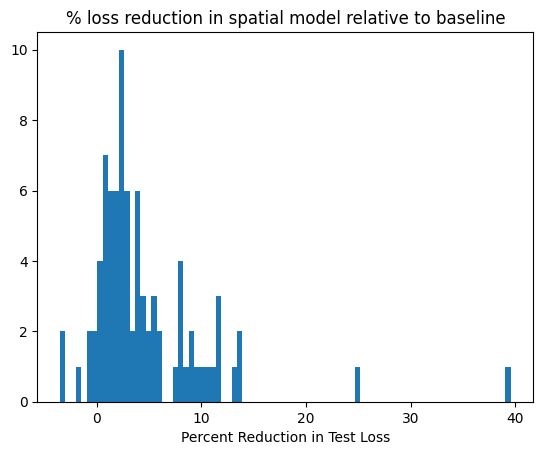

In [63]:
plt.hist(percent_differences, bins=len(loss_dict))
plt.title("% loss reduction in spatial model relative to baseline")
plt.xlabel("Percent Reduction in Test Loss")
plt.show()

# Identify the genes.

In [76]:
loss_dict_sorted = dict(sorted(loss_dict.items(), key=lambda item: item[1]["percent_diff"]))

In [77]:
loss_dict_sorted

{'Nnat': {'base': tensor(0.0100),
  'spatial': tensor(0.0061),
  'diff': tensor(-0.0040),
  'percent_diff': tensor(-39.5866)},
 'Mbp': {'base': tensor(0.0544),
  'spatial': tensor(0.0409),
  'diff': tensor(-0.0135),
  'percent_diff': tensor(-24.8099)},
 'Ebf3': {'base': tensor(0.1611),
  'spatial': tensor(0.1390),
  'diff': tensor(-0.0221),
  'percent_diff': tensor(-13.7119)},
 'Sln': {'base': tensor(0.0535),
  'spatial': tensor(0.0463),
  'diff': tensor(-0.0072),
  'percent_diff': tensor(-13.4800)},
 'Ermn': {'base': tensor(0.7739),
  'spatial': tensor(0.6704),
  'diff': tensor(-0.1035),
  'percent_diff': tensor(-13.3741)},
 'Cd24a': {'base': tensor(0.4986),
  'spatial': tensor(0.4402),
  'diff': tensor(-0.0584),
  'percent_diff': tensor(-11.7219)},
 'Greb1': {'base': tensor(0.2096),
  'spatial': tensor(0.1852),
  'diff': tensor(-0.0244),
  'percent_diff': tensor(-11.6531)},
 'Myh11': {'base': tensor(0.2398),
  'spatial': tensor(0.2121),
  'diff': tensor(-0.0277),
  'percent_diff': te

# Annotated Plot

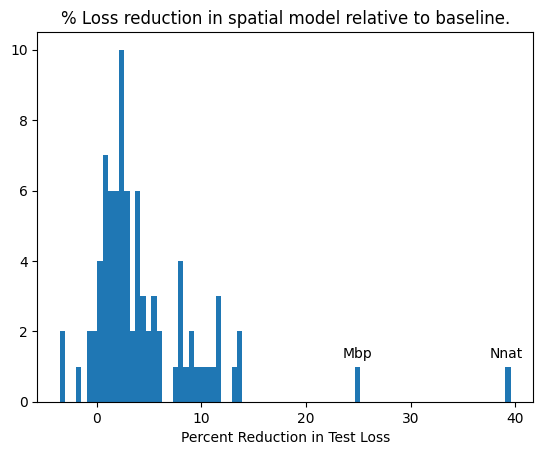

In [91]:
plt.hist(percent_differences, bins=len(loss_dict))
plt.title("% Loss reduction in spatial model relative to baseline.")
plt.xlabel("Percent Reduction in Test Loss")
plt.annotate("Nnat", xy=(39.5866-2, 1.25))
plt.annotate("Mbp", xy=(24.8099-1.3, 1.25))
plt.savefig("0VSspatial.png", dpi=300)
plt.show()

In [4]:
loss_dict = {'Nnat': {'base': 0.0100,
  'spatial': 0.0061,
  'diff': -0.0040,
  'percent_diff': -39.5866},
 'Mbp': {'base': 0.0544,
  'spatial': 0.0409,
  'diff': -0.0135,
  'percent_diff': -24.8099},
 'Ebf3': {'base': 0.1611,
  'spatial': 0.1390,
  'diff': -0.0221,
  'percent_diff': -13.7119},
 'Sln': {'base': 0.0535,
  'spatial': 0.0463,
  'diff': -0.0072,
  'percent_diff': -13.4800},
 'Ermn': {'base': 0.7739,
  'spatial': 0.6704,
  'diff': -0.1035,
  'percent_diff': -13.3741},
 'Cd24a': {'base': 0.4986,
  'spatial': 0.4402,
  'diff': -0.0584,
  'percent_diff': -11.7219},
 'Greb1': {'base': 0.2096,
  'spatial': 0.1852,
  'diff': -0.0244,
  'percent_diff': -11.6531},
 'Myh11': {'base': 0.2398,
  'spatial': 0.2121,
  'diff': -0.0277,
  'percent_diff': -11.5574},
 'Sgk1': {'base': 0.9204,
  'spatial': 0.8201,
  'diff': -0.1002,
  'percent_diff': -10.8921},
 'Gda': {'base': 0.5421,
  'spatial': 0.4851,
  'diff': -0.0570,
  'percent_diff': -10.5127},
 'Ndrg1': {'base': 0.9299,
  'spatial': 0.8371,
  'diff': -0.0928,
  'percent_diff': -9.9785},
 'Irs4': {'base': 0.7354,
  'spatial': 0.6657,
  'diff': -0.0696,
  'percent_diff': -9.4674},
 'Rgs5': {'base': 0.6153,
  'spatial': 0.5595,
  'diff': -0.0558,
  'percent_diff': -9.0649},
 'Gjc3': {'base': 0.5288,
  'spatial': 0.4812,
  'diff': -0.0476,
  'percent_diff': -8.9972},
 'Necab1': {'base': 0.5853,
  'spatial': 0.5363,
  'diff': -0.0490,
  'percent_diff': -8.3682},
 'Syt2': {'base': 0.3222,
  'spatial': 0.2963,
  'diff': -0.0259,
  'percent_diff': -8.0430},
 'Dgkk': {'base': 0.5685,
  'spatial': 0.5229,
  'diff': -0.0456,
  'percent_diff': -8.0251},
 'Aqp4': {'base': 0.7679,
  'spatial': 0.7073,
  'diff': -0.0605,
  'percent_diff': -7.8794},
 'Arhgap36': {'base': 0.5414,
  'spatial': 0.4992,
  'diff': -0.0421,
  'percent_diff': -7.7839},
 'Slc17a6': {'base': 0.5286,
  'spatial': 0.4891,
  'diff': -0.0395,
  'percent_diff': -7.4780},
 'Sytl4': {'base': 0.4158,
  'spatial': 0.3913,
  'diff': -0.0244,
  'percent_diff': -5.8718},
 'Slco1a4': {'base': 0.3741,
  'spatial': 0.3527,
  'diff': -0.0214,
  'percent_diff': -5.7163},
 'Nos1': {'base': 0.4764,
  'spatial': 0.4502,
  'diff': -0.0262,
  'percent_diff': -5.4903},
 'Pou3f2': {'base': 0.4549,
  'spatial': 0.4304,
  'diff': -0.0246,
  'percent_diff': -5.3983},
 'Opalin': {'base': 0.3341,
  'spatial': 0.3165,
  'diff': -0.0175,
  'percent_diff': -5.2503},
 'Lmod1': {'base': 0.1470,
  'spatial': 0.1399,
  'diff': -0.0071,
  'percent_diff': -4.8374},
 'Onecut2': {'base': 0.3949,
  'spatial': 0.3762,
  'diff': -0.0186,
  'percent_diff': -4.7191},
 'Ar': {'base': 0.5081,
  'spatial': 0.4852,
  'diff': -0.0229,
  'percent_diff': -4.5077},
 'Col25a1': {'base': 0.3641,
  'spatial': 0.3482,
  'diff': -0.0159,
  'percent_diff': -4.3753},
 'Chat': {'base': 0.2013,
  'spatial': 0.1928,
  'diff': -0.0085,
  'percent_diff': -4.2069},
 'Sox6': {'base': 0.4160,
  'spatial': 0.3989,
  'diff': -0.0171,
  'percent_diff': -4.1189},
 'Aldh1l1': {'base': 0.6029,
  'spatial': 0.5787,
  'diff': -0.0243,
  'percent_diff': -4.0244},
 'Isl1': {'base': 0.1714,
  'spatial': 0.1647,
  'diff': -0.0067,
  'percent_diff': -3.9121},
 'Man1a': {'base': 0.5312,
  'spatial': 0.5114,
  'diff': -0.0198,
  'percent_diff': -3.7253},
 'Ano3': {'base': 0.1944,
  'spatial': 0.1872,
  'diff': -0.0072,
  'percent_diff': -3.6989},
 'Cspg5': {'base': 0.6093,
  'spatial': 0.5868,
  'diff': -0.0225,
  'percent_diff': -3.6890},
 'Syt4': {'base': 0.4220,
  'spatial': 0.4074,
  'diff': -0.0146,
  'percent_diff': -3.4530},
 'Synpr': {'base': 0.3529,
  'spatial': 0.3410,
  'diff': -0.0120,
  'percent_diff': -3.3943},
 'Pcdh11x': {'base': 0.4673,
  'spatial': 0.4529,
  'diff': -0.0144,
  'percent_diff': -3.0916},
 'Serpinb1b': {'base': 0.1769,
  'spatial': 0.1715,
  'diff': -0.0054,
  'percent_diff': -3.0600},
 'Sp9': {'base': 0.1562,
  'spatial': 0.1516,
  'diff': -0.0045,
  'percent_diff': -2.9082},
 'Etv1': {'base': 0.3147,
  'spatial': 0.3058,
  'diff': -0.0089,
  'percent_diff': -2.8321},
 'Npas1': {'base': 0.2042,
  'spatial': 0.1987,
  'diff': -0.0055,
  'percent_diff': -2.7172},
 'Amigo2': {'base': 0.4131,
  'spatial': 0.4019,
  'diff': -0.0112,
  'percent_diff': -2.7046},
 'Gbx2': {'base': 0.1176,
  'spatial': 0.1146,
  'diff': -0.0030,
  'percent_diff': -2.5747},
 'Ccnd2': {'base': 0.3582,
  'spatial': 0.3492,
  'diff': -0.0090,
  'percent_diff': -2.5164},
 'Cyp19a1': {'base': 0.1863,
  'spatial': 0.1818,
  'diff': -0.0045,
  'percent_diff': -2.4242},
 'Fezf1': {'base': 0.1828,
  'spatial': 0.1784,
  'diff': -0.0043,
  'percent_diff': -2.3544},
 'Pgr': {'base': 0.2455,
  'spatial': 0.2397,
  'diff': -0.0057,
  'percent_diff': -2.3300},
 'Sox4': {'base': 0.5972,
  'spatial': 0.5833,
  'diff': -0.0139,
  'percent_diff': -2.3267},
 'Esr1': {'base': 0.2147,
  'spatial': 0.2097,
  'diff': -0.0050,
  'percent_diff': -2.3158},
 'Slc17a8': {'base': 0.0933,
  'spatial': 0.0912,
  'diff': -0.0021,
  'percent_diff': -2.2369},
 'Klf4': {'base': 0.2457,
  'spatial': 0.2402,
  'diff': -0.0055,
  'percent_diff': -2.2185},
 'Rnd3': {'base': 0.4582,
  'spatial': 0.4483,
  'diff': -0.0100,
  'percent_diff': -2.1733},
 'Scgn': {'base': 0.2175,
  'spatial': 0.2130,
  'diff': -0.0045,
  'percent_diff': -2.0781},
 'Ndnf': {'base': 0.2608,
  'spatial': 0.2557,
  'diff': -0.0052,
  'percent_diff': -1.9759},
 'Cenpe': {'base': 0.2510,
  'spatial': 0.2461,
  'diff': -0.0049,
  'percent_diff': -1.9331},
 'Ace2': {'base': 0.1447,
  'spatial': 0.1421,
  'diff': -0.0027,
  'percent_diff': -1.8325},
 'Creb3l1': {'base': 0.4164,
  'spatial': 0.4088,
  'diff': -0.0076,
  'percent_diff': -1.8323},
 'Gem': {'base': 0.1573,
  'spatial': 0.1547,
  'diff': -0.0027,
  'percent_diff': -1.6874},
 'Ttyh2': {'base': 0.5572,
  'spatial': 0.5485,
  'diff': -0.0087,
  'percent_diff': -1.5653},
 'Mlc1': {'base': 0.6873,
  'spatial': 0.6770,
  'diff': -0.0102,
  'percent_diff': -1.4903},
 'Coch': {'base': 0.1908,
  'spatial': 0.1881,
  'diff': -0.0027,
  'percent_diff': -1.4020},
 'Omp': {'base': 0.3716,
  'spatial': 0.3666,
  'diff': -0.0050,
  'percent_diff': -1.3336},
 'Plin3': {'base': 0.4102,
  'spatial': 0.4054,
  'diff': -0.0048,
  'percent_diff': -1.1792},
 'Cplx3': {'base': 0.1714,
  'spatial': 0.1695,
  'diff': -0.0019,
  'percent_diff': -1.0909},
 'Th': {'base': 0.0270,
  'spatial': 0.0267,
  'diff': -0.0003,
  'percent_diff': -1.0107},
 'Fbxw13': {'base': 0.1029,
  'spatial': 0.1019,
  'diff': -0.0010,
  'percent_diff': -1.0092},
 'Ttn': {'base': 0.1203,
  'spatial': 0.1191,
  'diff': -0.0012,
  'percent_diff': -0.9756},
 'Cyp26a1': {'base': 0.0739,
  'spatial': 0.0733,
  'diff': -0.0006,
  'percent_diff': -0.8513},
 'Tiparp': {'base': 0.4689,
  'spatial': 0.4655,
  'diff': -0.0034,
  'percent_diff': -0.7220},
 'Cdkn1a': {'base': 0.3948,
  'spatial': 0.3921,
  'diff': -0.0027,
  'percent_diff': -0.6800},
 'Sox8': {'base': 0.4829,
  'spatial': 0.4800,
  'diff': -0.0028,
  'percent_diff': -0.5901},
 'Krt90': {'base': 0.1343,
  'spatial': 0.1339,
  'diff': -0.0004,
  'percent_diff': -0.3340},
 'Nup62cl': {'base': 0.1169,
  'spatial': 0.1166,
  'diff': -0.0004,
  'percent_diff': -0.3041},
 'Slc15a3': {'base': 0.1355,
  'spatial': 0.1353,
  'diff': -0.0002,
  'percent_diff': -0.1759},
 'Mki67': {'base': 0.1412,
  'spatial': 0.1410,
  'diff': -0.0002,
  'percent_diff': -0.1592},
 'Rgs2': {'base': 0.4003,
  'spatial': 0.4009,
  'diff': 0.0007,
  'percent_diff': 0.1664},
 'Tmem108': {'base': 0.3853,
  'spatial': 0.3864,
  'diff': 0.0011,
  'percent_diff': 0.2811},
 'Traf4': {'base': 0.2582,
  'spatial': 0.2598,
  'diff': 0.0017,
  'percent_diff': 0.6451},
 'Egr2': {'base': 0.1599,
  'spatial': 0.1612,
  'diff': 0.0012,
  'percent_diff': 0.7787},
 'Pak3': {'base': 0.5488,
  'spatial': 0.5598,
  'diff': 0.0110,
  'percent_diff': 2.0039},
 'Baiap2': {'base': 0.3369,
  'spatial': 0.3473,
  'diff': 0.0105,
  'percent_diff': 3.1029},
 'Cpne5': {'base': 0.2771,
  'spatial': 0.2869,
  'diff': 0.0098,
  'percent_diff': 3.5446}}

In [8]:
loss_diffs = np.array([loss_dict[x]["percent_diff"] for x in loss_dict])

In [9]:
np.mean(loss_diffs)

-4.562490476190477

In [11]:
np.mean(loss_diffs < 0)

0.9166666666666666

In [12]:
np.median(loss_diffs)

-2.7746500000000003